<a href="https://colab.research.google.com/github/Olivier-Patrick/Machine-learning/blob/master/Network_Analysis_claims_insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import time
#from numba import jit
import itertools
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import k_clique_communities
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.classes.function import path_weight

In [ ]:
data_network= pd.read_csv("/content/network_data.csv")

In [ ]:
claim_fraud = [x for x in data_network[data_network['fraud']=='Yes'].ClaimID]
claim_no_fraud = [x for x in data_network[data_network['fraud']=='No'].ClaimID]
claims =  claim_fraud + claim_no_fraud

In [ ]:
# Construction du réseau
def construct_network(data):
    zipped = zip(data.ClaimID, data.BeneID, data.Provider, data.AttendingPhysician )
    G = nx.Graph()
    for i, elmt in enumerate(list(zipped)):
        k, e1, e2, e3 = elmt
        G.add_node(k, bipartite=0)
        for node in [e1, e2, e3]:
            G.add_node(node, bipartite=1)
            G.add_edge(k, node,weight=1)
    return G

graph = construct_network(data_network)

In [ ]:
def get_colors_graph(data):
    claim_fraud = [x for x in data[data['fraud']=='Yes'].ClaimID]
    claim_normal = [x for x in data[data['fraud']=='No'].ClaimID]
    color = []
    for node in list(graph.nodes()):
        if node in claim_fraud:
            color.append('red')
        elif node in  claim_normal:
            color.append('green')
        else :
            color.append('blue')
    return color

In [ ]:
color = get_colors_graph(data_network)

In [ ]:
def get_communities(G, k_clique):
    cls = nx.find_cliques(G)
    communities = list(k_clique_communities(G,k_clique ,cliques = cls))
    return communities

In [ ]:
def get_color_community(communities,fraud, no_fraud):

    color = []
    for node in list(communities):
        if node in fraud:
            color.append('red')
        elif node in  no_fraud:
            color.append('green')
        else :
            color.append('blue')
    return color

In [ ]:
def plot_single_community(graph,community, fraud, no_fraud):

    # positions pour tous les noeuds
    pos = nx.spring_layout(graph)


    plt.figure(figsize=(12,12))

    colors = get_color_community(community,fraud,no_fraud)
    nx.draw_networkx_nodes(graph,pos,nodelist=list(community),node_color=colors)

    nx.draw_networkx_edges(graph,pos,width=0.5)
    # labels
    nx.draw_networkx_labels(graph,pos,font_size=10,font_family='sans-serif')

    plt.axis('off')
    plt.show()

In [ ]:
communities = get_communities(graph,2)

In [ ]:
community = []
for c in communities:
    if len(list(c)) > 4:
        community.append(c)
print(len(community))

74


In [ ]:
def AllPaths(graph):
    #all_paths = []
    #nodes_combs = itertools.combinations(graph.nodes, 2)
    #all_paths = [ nx.all_simple_paths(graph, source=source, target=target)[:]
                 #for source, target in itertools.combinations(graph.nodes, 2) ]
        #paths = nx.all_simple_paths(graph, source=source, target=target)
        #all_paths += nx.all_simple_paths(graph, source=source, target=target)
        #print(len(all_paths))

        #for path in paths:
            #if path not in all_paths and path[::-1] not in all_paths:
                #all_paths.append(path)
    return [ i for source, target in itertools.combinations(graph.nodes, 2)
            for i in nx.all_simple_paths(graph, source=source, target=target)]

In [ ]:
def SOWOP(graph,path):
    return path_weight(graph, path,'weight')

In [ ]:
def AOWOP(all_paths):
    return sum([path_weight(graph, path,'weight') for path in all_paths])/len(all_paths)

In [ ]:
def PathElement(graph,i,F,all_paths):
    paths = nx.all_simple_paths(graph, source=i, target=F)
    aowop = AOWOP(all_paths)
    return sum([1 if SOWOP(graph,path)> aowop else SOWOP(graph,path)/aowop for path in paths])

In [ ]:
def PathElements(graph,i,claim_fraud,all_paths):
    return sum([PathElement(graph,i,F,all_paths) for F in claim_fraud])/len(all_paths)

In [ ]:
def WOIE(path):
    return sum([i[1] for i in list(graph.degree(path))])

In [ ]:
def AOWOE(graph):
    return sum([i[1] for i in list(graph.degree(list(graph.nodes())))])/len(list(graph.nodes()))

In [ ]:
def DegreeElement(graph,i,F):
    paths = nx.all_simple_paths(graph, source=i, target=F)
    aowoe = AOWOE(graph)
    return sum([0 if WOIE(path)/(aowoe*(path_weight(graph, path,'weight'))) >= 1 else 1/WOIE(path)/(aowoe*(path_weight(graph, path,'weight'))) for path in paths ])


In [ ]:
def DegreeElements(graph,i,claim_fraud,all_paths):
    return sum([DegreeElement(graph,i,F) for F in claim_fraud])/len(all_paths)

In [ ]:
def EndPointElements(graph,i):
    return len([l  for l in list(graph.neighbors(i)) if l in claim_fraud])/len(list(graph.neighbors(i)))

In [ ]:
def fake_score(graph,i,claim_fraud,all_paths,A=0.5,B= 0.1):

    return A*PathElements(graph,i,claim_fraud,all_paths) + \
           B*DegreeElements(graph,i,claim_fraud,all_paths) + \
           (1-(A+B))*EndPointElements(graph,i)

In [ ]:
def score_fraud_community(graph,community,claims,claim_fraud,all_paths):
    c = [x for x in list(community) if x not in claims ] # all node that not claims
    return sum([fake_score(graph,p,claim_fraud,all_chemins) for p in c])/len(c)

In [ ]:
all_chemins = AllPaths(graph)
len(all_chemins)

5982

In [ ]:
fs=[score_fraud_community(graph,j,claims,claim_fraud,all_chemins) for j in community]

In [ ]:
nombre_fraud = []
nombre_noeuds = []
for c in community:
  nombre_noeuds.append(len(list(c)))
  s = 0
  for i in c :
    if i in claim_fraud:
       s += 1
  nombre_fraud.append(s)

In [ ]:
df = pd.DataFrame(list(zip(nombre_noeuds, nombre_fraud,fs)), columns = ['nbr_noeuds', 'nbr_fraud','fake_score'])

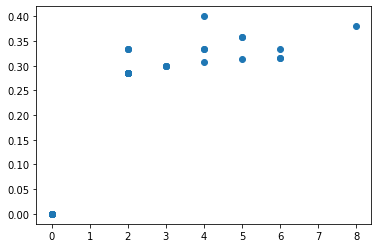

In [ ]:
#plt.scatter(df.nbr_fraud, df.fake_score)
plt.scatter(df.nbr_fraud, df.nbr_fraud/df.nbr_noeuds)

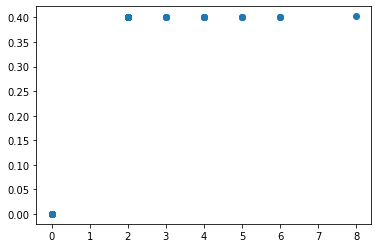

In [ ]:
plt.scatter(df.nbr_fraud, df.fake_score)

In [ ]:
df.to_csv("analysis_network_fraud.csv")